In [2]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizer, DistilBertModel
import torch
import numpy as np
import pickle
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

C:\Users\Kovaech\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Kovaech\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [3]:
# change path to Dataset file
df = pd.read_csv('D:\\Master 2 TAL\\Neural networks\\dataset.csv')
df.loc[:,'language'].unique()

array(['Estonian', 'Swedish', 'Thai', 'Tamil', 'Dutch', 'Japanese',
       'Turkish', 'Latin', 'Urdu', 'Indonesian', 'Portugese', 'French',
       'Chinese', 'Korean', 'Hindi', 'Spanish', 'Pushto', 'Persian',
       'Romanian', 'Russian', 'English', 'Arabic'], dtype=object)

## Data Encoding and Pre-prrocessing ( Using BERT Embeddings : Intensive Calculation ) 

In [4]:
# enconding labels of langauges into unique numbers of their own: each number represents a language
le = LabelEncoder()
text_labels = df.iloc[:, 1]

# Fit transform the labels
encoded_labels = le.fit_transform(text_labels)

# Creating a mapping between original labels and encoded labels
label_mapping = dict(zip(text_labels, encoded_labels))

# To find which label is encoded with a certain number, you can invert the mapping
# Let's say you want to find which label is encoded with number 0
encoded_label_to_find = 4
for label, encoded_label in label_mapping.items():
    if encoded_label == encoded_label_to_find:
        print(f"The label '{label}' is encoded as {encoded_label_to_find}")

The label 'Estonian' is encoded as 4


### BERT embeddings extraction : ( if got embeddings, ignore )

In [218]:
## Initializing BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
bert_model = BertModel.from_pretrained('bert-base-multilingual-cased')

In [ ]:
#preparing BERT's word IDs to extract pre-trained embeddings
total_ids = []
attention_masks = []

# For every sentence...
for sent in df.iloc[:, 0]:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to split into tokens
                        add_special_tokens=True,   # Add special token '[CLS]' and '[SEP]'
                        max_length=512,             # Pad & truncate all sentences.
                        pad_to_max_length=True,
                        return_attention_mask=True,   # Construct attention masks.
                        return_tensors='pt',       # Return PyTorch tensors.
                   )
    
    # Adding the encoded sentence to the list.    
    total_ids.append(encoded_dict['input_ids'])
    
    # Attention mask (to differentiate padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

In [ ]:
# extracting pre-trained embeddings from BERT  !! Intensive Calculation ALERT !! 
with torch.inference_mode():
    bert_embeddings = bert_model(input_ids=total_ids, attention_mask=attention_masks)

In [ ]:
# saving embeddings and labels of the data inside the computer for outside use
data_to_save = (bert_embeddings, encoded_labels)

# Save variables to a file using pickle
with open('path/to/your/file.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)

## Loading embeddings and preparing Data

In [5]:
# loading saved embeddings of BERT
import pickle

# Specify the path to your pickle file
pickle_file_path = 'D:\\Master 2 TAL\\Neural networks\\project\\file.pkl'

# Open the pickle file in binary read mode ('rb')
with open(pickle_file_path, 'rb') as file:
    # Load the data from the pickle file
    data = pickle.load(file)

In [6]:
## Defining Variables of features and labels to be fed into the model for training 
X_features = data[0].pooler_output
y_labels = encoded_labels
X_features = torch.Tensor(X_features)
y_labels_tensor = torch.Tensor(y_labels)

In [7]:
print('shape of x embeddings: ',X_features.shape)
print('shape of y labels: ',y_labels_tensor.shape)

shape of x embeddings:  torch.Size([22000, 768])
shape of y labels:  torch.Size([22000])


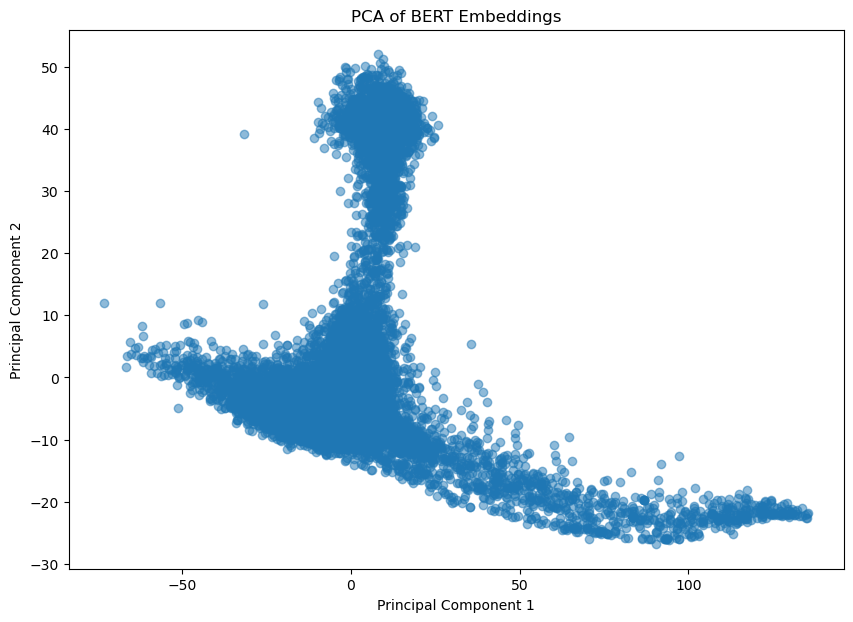

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming X_tensor is your [22000, 768] PyTorch tensor
# Generate some random data for demonstration purposes
torch.manual_seed(42)

# Convert PyTorch tensor to NumPy array
X_np = X_features.numpy()

# Step 1: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_np)

# Step 2: Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 3: Visualize the data
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title('PCA of BERT Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

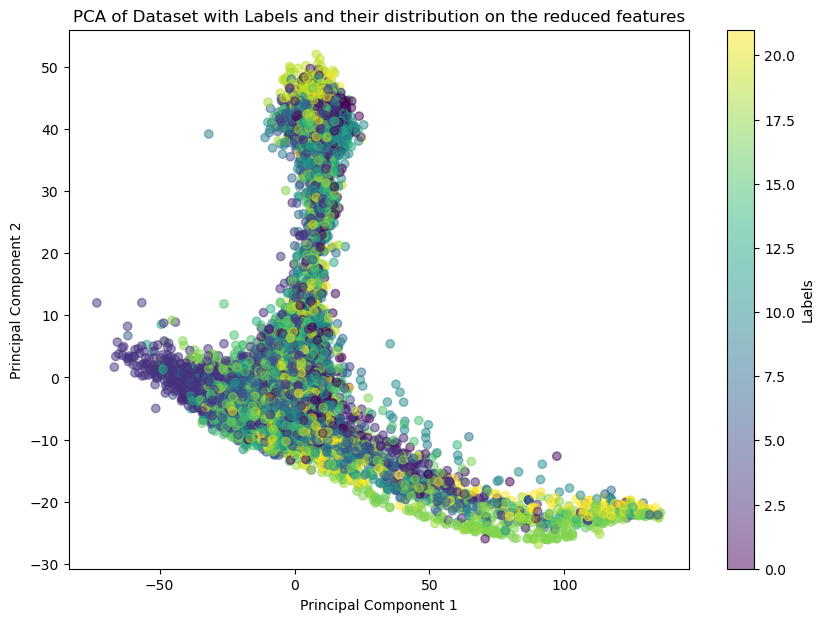

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the labels tensor to a NumPy array for plotting
y_np = y_labels_tensor.numpy()

# Assuming X_pca is the PCA-reduced data you computed earlier
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_np, alpha=0.5, cmap='viridis')
plt.title('PCA of Dataset with Labels and their distribution on the reduced features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Labels')
plt.show()


In [10]:
# Setting up device agnostic Tensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
X_features= X_features.to(device) 
y_labels_tensor= y_labels_tensor.type(torch.LongTensor)
y_labels_tensor= y_labels_tensor.to(device)

In [12]:
X_features.device, y_labels_tensor.device

(device(type='cuda', index=0), device(type='cuda', index=0))

In [13]:

#Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels_tensor, test_size=0.3, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



# Step 3: Create TensorDatasets
#train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
#val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
#test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [14]:
len(X_train),len(X_test),len(y_train),len(y_test)

(15400, 6600, 15400, 6600)

In [15]:
y_train = y_train.to(device)
y_test = y_test.to(device)

In [17]:
y_test.device,y_train.device

(device(type='cuda', index=0), device(type='cuda', index=0))

## Construct a Feed forward Neural Network + Training

In [44]:
model = nn.Sequential(
    nn.Linear(768, 512),  # First layer with more neurons
    nn.ReLU(),            # Activation function
    nn.BatchNorm1d(512),  # Batch normalization
    nn.Dropout(0.5),      # Dropout for regularization
    
    nn.Linear(512, 256),  # Additional hidden layer
    nn.ReLU(),            # Activation function
    nn.BatchNorm1d(256),  # Batch normalization
    nn.Dropout(0.3),      # Dropout for regularization
    
    nn.Linear(256, 128),  # Additional hidden layer
    nn.ReLU(),            # Activation function
    nn.BatchNorm1d(128),  # Batch normalization
    nn.Dropout(0.2),      # Dropout for regularization
    
    nn.Linear(128, 64),   # Additional hidden layer
    nn.ReLU(),            # Activation function
    nn.BatchNorm1d(64),   # Batch normalization
    nn.Dropout(0.1),      # Dropout for regularization
    
    nn.Linear(64, 22),    # Output layer for 22 classes
    nn.Softmax(dim=1)     # Softmax for the output layer
)


In [46]:
model = model.to(device)

In [50]:
loss_entropy = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.01)

In [52]:
model

Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.3, inplace=False)
  (8): Linear(in_features=256, out_features=128, bias=True)
  (9): ReLU()
  (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=128, out_features=64, bias=True)
  (13): ReLU()
  (14): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): Dropout(p=0.1, inplace=False)
  (16): Linear(in_features=64, out_features=22, bias=True)
  (17): Softmax(dim=1)
)

In [56]:

epochs = 500
epoch_count = []
train_losses = []
test_losses = []
train_accuracies = []  # Store training accuracies
test_accuracies = []  # Store test accuracies
best_loss = float('inf')
best_model_state = model.state_dict()  # Initialize best_model_state

for epoch in range(epochs):
    epoch_count.append(epoch)
    
    # Training phase
    model.train()
    initial_preds = model(X_train)
    train_loss = loss_entropy(initial_preds, y_train)
    train_losses.append(train_loss.item())  # Ensure to call .item() for scalar value
    
    # Calculate training accuracy
    _, predicted_labels_train = torch.max(initial_preds, 1)
    correct_train = (predicted_labels_train == y_train).float().sum()
    train_accuracy = (correct_train / y_train.size(0)) * 100  # Convert to percentage
    train_accuracies.append(train_accuracy.item())  # Store as scalar value
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    # Evaluation phase
    model.eval()
    with torch.inference_mode():  
        test_pred = model(X_test)
        test_loss = loss_entropy(test_pred, y_test)
        test_losses.append(test_loss.item())  # Ensure to call .item() for scalar value
        
        # Calculate test accuracy
        _, predicted_labels_test = torch.max(test_pred, 1)
        correct_test = (predicted_labels_test == y_test).float().sum()
        test_accuracy = (correct_test / y_test.size(0)) * 100  # Convert to percentage
        test_accuracies.append(test_accuracy.item())  # Store as scalar value
        
        # Update best model if current test loss is lower
        if test_loss < best_loss:
            best_loss = test_loss
            best_model_state = model.state_dict()
    
    if (epoch + 1) % 100 == 0:  # Print status every 100 epochs
        print(f"** Epoch {epoch + 1}: Train Loss: {train_loss:.5f}, Test Loss: {test_loss:.5f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")


** Epoch 100: Train Loss: 2.18282, Test Loss: 2.18506, Train Accuracy: 98.38%, Test Accuracy: 98.12%
** Epoch 200: Train Loss: 2.18141, Test Loss: 2.18512, Train Accuracy: 98.52%, Test Accuracy: 98.09%
** Epoch 300: Train Loss: 2.18404, Test Loss: 2.18529, Train Accuracy: 98.25%, Test Accuracy: 98.09%
** Epoch 400: Train Loss: 2.18137, Test Loss: 2.18626, Train Accuracy: 98.51%, Test Accuracy: 97.98%
** Epoch 500: Train Loss: 2.18007, Test Loss: 2.18297, Train Accuracy: 98.62%, Test Accuracy: 98.33%


In [58]:
best_loss


tensor(2.1823, device='cuda:0')

In [72]:
type(train_losses[0])

float

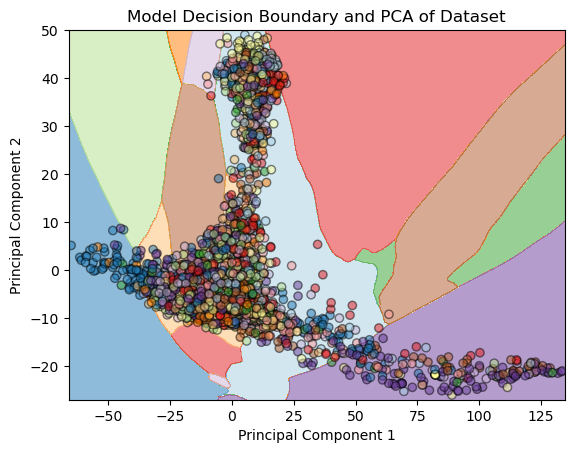

In [60]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming X_tensor is your [22000, 768] PyTorch tensor and you have a corresponding labels tensor y_tensor
torch.manual_seed(42)

# Convert PyTorch tensor to NumPy array for features and labels
X_np = X_test.cpu().numpy()  # Move X_test tensor to CPU and then convert to NumPy array
y_np = y_test.cpu().numpy()  # Move y_test tensor to CPU and then convert to NumPy array


# Step 1: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_np)

# Step 2: Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Function to plot decision boundary for a PyTorch model
def plot_decision_boundary_pytorch(X, y, model, device, steps=1000, cmap='Paired'):
    model.to(device)
    model.eval()  # Put the model in evaluation mode
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, steps), np.linspace(y_min, y_max, steps))

    # Preprocess grid points
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_original_space = pca.inverse_transform(grid)  # Transform back to original space
    grid_original_space = scaler.inverse_transform(grid_original_space)  # Inverse scaling
    grid_tensor = torch.tensor(grid_original_space, dtype=torch.float).to(device)

    # Predict using the PyTorch model
    with torch.no_grad():
        preds = model(grid_tensor).cpu().numpy()
        preds = np.argmax(preds, axis=1).reshape(xx.shape)

    # Plotting
    plt.contourf(xx, yy, preds, alpha=0.5, levels=np.unique(y), cmap=cmap)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, edgecolor='k', cmap=cmap)
    plt.title('Model Decision Boundary and PCA of Dataset')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Assuming `model` is your trained PyTorch model and `device` is your device ('cuda' or 'cpu')
plot_decision_boundary_pytorch(X_pca, y_np, model, device='cuda')  # Adjust 'cpu' to 'cuda' if using GPU


In [61]:
#loading the model's best state_dict from the trainig loop
model.load_state_dict(best_model_state)
model

Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.3, inplace=False)
  (8): Linear(in_features=256, out_features=128, bias=True)
  (9): ReLU()
  (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=128, out_features=64, bias=True)
  (13): ReLU()
  (14): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): Dropout(p=0.1, inplace=False)
  (16): Linear(in_features=64, out_features=22, bias=True)
  (17): Softmax(dim=1)
)

In [64]:
import numpy as np
import matplotlib.pyplot as plt

def plot_loss(epochs, train_loss, test_loss, title='Training and Test Loss', smooth_factor=0.6):
    """
    Plot the smoothed training and test loss over epochs.

    Parameters:
    - epochs: Number of epochs or a list of epoch indices.
    - train_loss: List or array of training loss values.
    - test_loss: List or array of test loss values.
    - title: Title of the plot.
    - smooth_factor: The weight factor for exponential moving average smoothing.
    """
    def smooth_curve(points, factor=smooth_factor):
        smoothed_points = []
        for point in points:
            if smoothed_points:
                previous = smoothed_points[-1]
                smoothed_points.append(previous * factor + point * (1 - factor))
            else:
                smoothed_points.append(point)
        return smoothed_points

    if isinstance(epochs, int):
        epochs = range(1, epochs + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, smooth_curve(train_loss), label='Train Loss', marker='o')
    plt.plot(epochs, smooth_curve(test_loss), label='Test Loss', marker='o')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

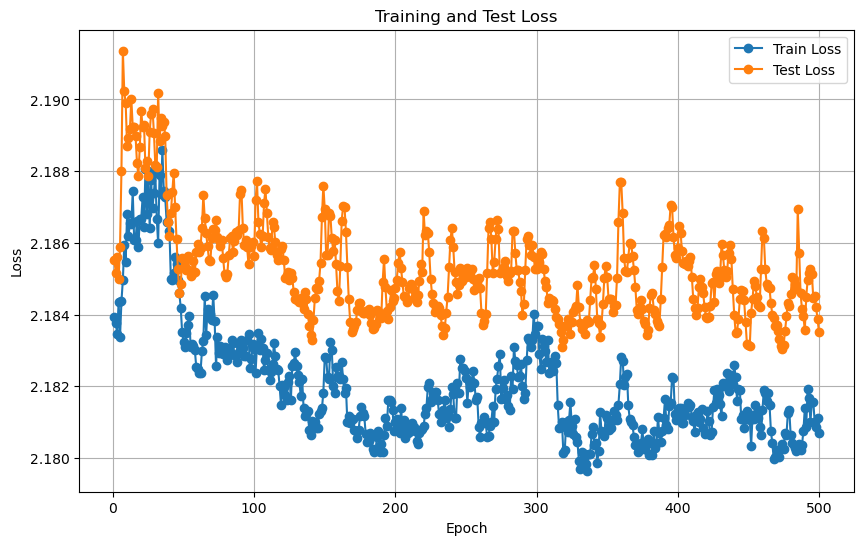

In [74]:
train_loss = []
test_loss = []
for train,test in zip(train_losses,test_losses):
    tensor_train = train
    tensor_test = test
    train_loss.append(tensor_train)
    test_loss.append(tensor_test)
plot_loss(epochs,train_loss,test_loss)

In [193]:
# saving model's parameter's in Local Machine
model_save_path = 'D:\\Master 2 TAL\\Neural networks\\project\\models\\my_model.pth'
torch.save(model.state_dict(), model_save_path)

## Testing Model Prediction

In [76]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
# Load the DistilBERT model
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')

In [78]:
sentence = "I am hungry"

In [80]:
# Tokenizing and encoding raw sentence into tensor embeddings from DistilBert
encoded_input = tokenizer(sentence, return_tensors='pt')
output = distilbert_model(**encoded_input)
output

BaseModelOutput(last_hidden_state=tensor([[[ 0.1416,  0.0717,  0.0369,  ...,  0.4926, -0.0580, -0.0324],
         [ 0.2313, -0.1988,  0.1170,  ...,  0.7482, -0.4302, -0.2403],
         [ 0.2175, -0.1456, -0.4553,  ...,  0.8304, -0.5651, -0.2378],
         [-0.0052, -0.4433, -0.5888,  ...,  0.0467, -0.1376, -0.1311],
         [-0.2488,  0.1406, -0.2710,  ...,  0.6301,  0.2789, -0.1695],
         [ 0.1834,  0.0575,  0.4836,  ...,  0.4811, -0.0476, -0.0158]]],
       grad_fn=<NativeLayerNormBackward0>), hidden_states=None, attentions=None)

In [82]:
# loading Bert tensor embeddings from DistilBert
sentence_embedding = output.last_hidden_state[:, 0, :]

In [84]:
# checking if the shape matches
sentence_embedding.shape

torch.Size([1, 768])

In [86]:
# predicting using the model
model.eval()
with torch.inference_mode():
    preds = model(sentence_embedding.to(device))
preds

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], device='cuda:0')

In [88]:
# Checking if it is the language used
predicted_index = preds.argmax()  # This finds the index of the maximum value in preds tensor, which is 0 in your case.
predicted_label = encoded_labels[predicted_index]
for label, encoded_label in label_mapping.items():
    if encoded_label == predicted_label:
        print(f"The language Predicted by the model is :{label}")

The language Predicted by the model is :Tamil
